## Problem Statement

### Context


AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help


### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


###  Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing necessary libraries and data

In [341]:
# import libraries needed for data ingest 
# and data transformation
import numpy as np   
import pandas as pd 

#import libraries for visualization
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

# import library for scaling data
from scipy.stats import zscore

# import libraries for clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 

# import libraries for clustering measurement and optimization
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist # pairwise distance

# import silhouette score for Kmeans
from sklearn.metrics import silhouette_samples, silhouette_score

# import time to stopwatch measure code execution
import time

# reindexing warning occurs, import and filter to suppress
import warnings
warnings.filterwarnings("ignore")

In [342]:
# read excel file and assign to cdata
cdata = pd.read_excel('datasets/Credit_Card_Customer_Data.xlsx')

cdata.head(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


## Data Overview

- Observations
- Sanity checks

In [343]:
# run shape to count rows and columns
cdata.shape

(660, 7)

In [344]:
# run dtype to understand what data types are included
cdata.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

In [345]:
# run describe with a Transpose to view stats
cdata.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


In [346]:
# run duplicated to determine if there are duplicate rows
# SI.no is some ID number and will be unique
# Customer Key is an ID also and will be unique
# index from column Avg_Credit_Limit onward
cdata.iloc[:, 2:].duplicated().sum()


# there are 11 rows that are duplicates
# each row is unique (unique Customer Key)
# so this can be ignored

11

In [347]:
# run info to understand if there is missing data
cdata.info()

# 660 rows are non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [348]:
# review missing data one more time with isna()
cdata.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

### Questions

1. How is the distrubution of average credit limit of customer?
2. What percenatage of the customers have never made a service-related call to the bank?
3. What percentage of customers have never logged in to the online portal?
4. How many customers have never visited bank?
3. How are the different variables correlated with each other?

### Univariate Analysis

In [349]:
# function to plot a boxplot and a histogram along the same scale.
# define a function for unvariate analysis


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="lightblue"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.text(x = data[feature].mean(),
        y = max([h.get_height() for h in ax_hist2.patches]),
        s = 'mean: {:,.1f}'.format(data[feature].mean()),
        color = 'darkgreen'
    ) # Add mean label to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    ax_hist2.text(x = data[feature].median(),
        y = max([h.get_height()-15 for h in ax_hist2.patches]),
        s = 'median: {:,.1f}'.format(data[feature].median()),
        color = 'purple'
    ) # Add median label to the histogram

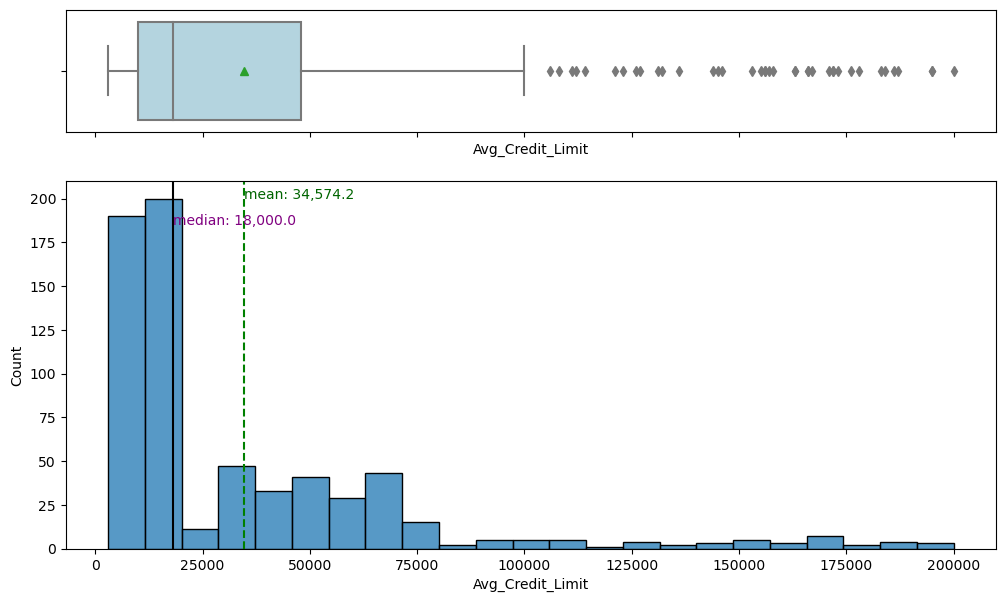

In [350]:
# visualize distribution of Avg_Credit_Limit
# understand outliers
# visualize mean and median
# median is 
histogram_boxplot(cdata, 'Avg_Credit_Limit')

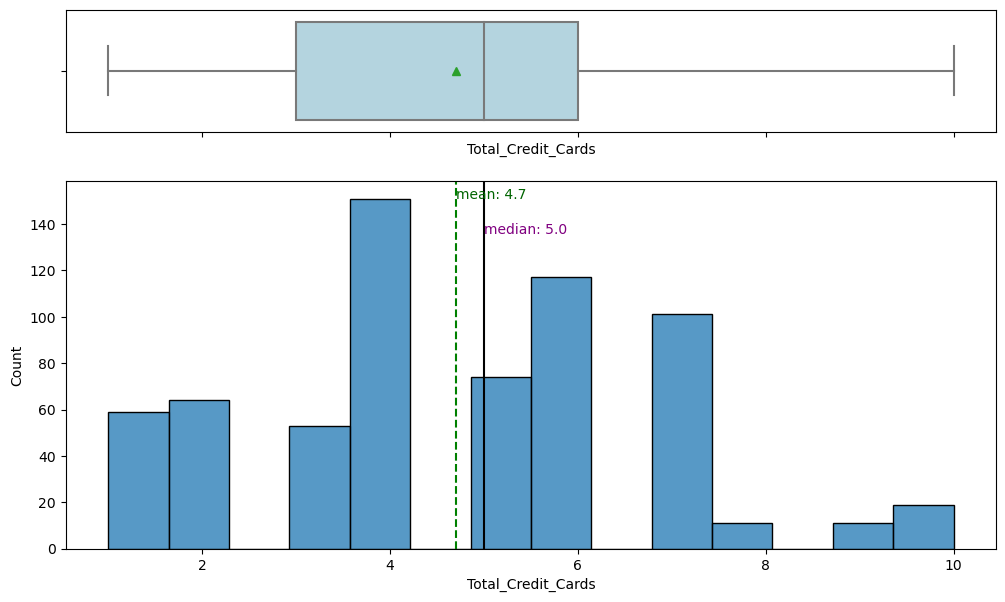

In [351]:
# visualize distribution of Total_Credit_Cards
# understand outliers
# visualize mean and median
# median is 
histogram_boxplot(cdata, 'Total_Credit_Cards')

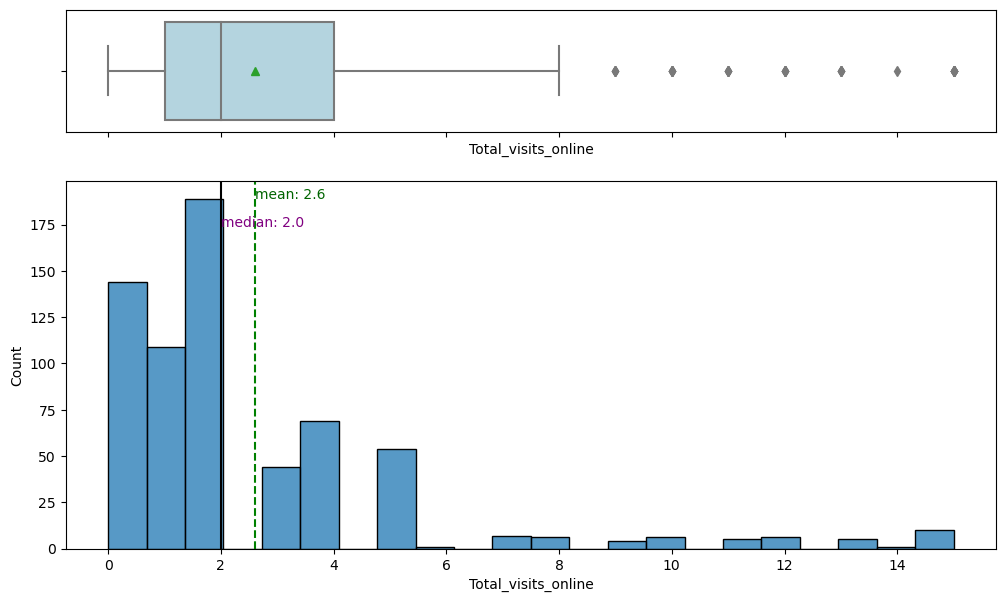

In [352]:
# visualize distribution of Total_visits_online
# understand outliers
# visualize mean and median
# median is 
histogram_boxplot(cdata, 'Total_visits_online')

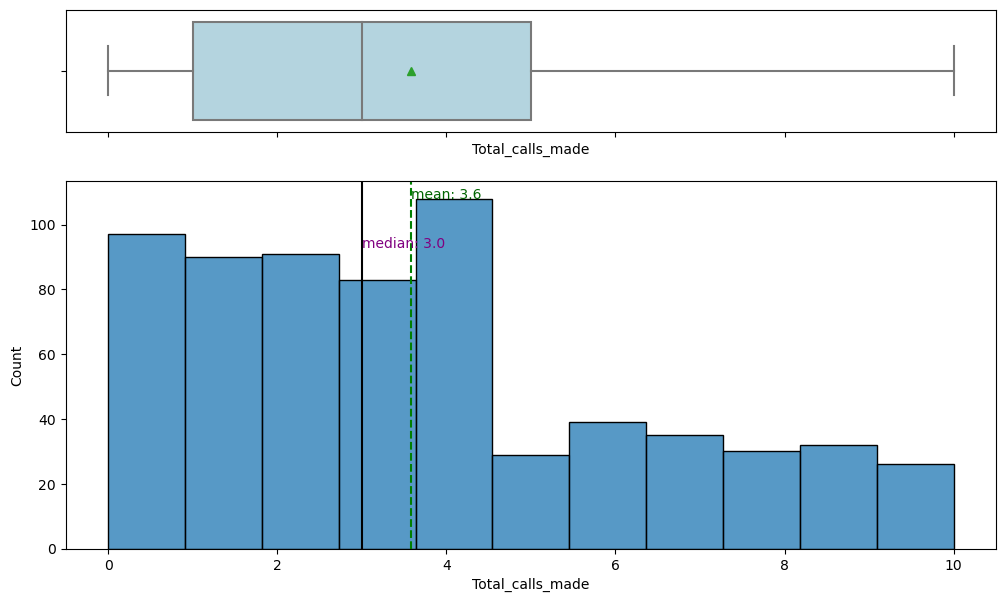

In [353]:
# visualize distribution of Total_calls_made
# understand outliers
# visualize mean and median
# median is 
histogram_boxplot(cdata, 'Total_calls_made')

In [354]:
cdata.columns[2:]

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

In [355]:
# use value_counts to understand counts and percentages
# for all columns except for SI.no and Customer Key
col_names = cdata.columns[2:]


for i in col_names:
    print(round(cdata[i].value_counts(1), 2))
    print('-' * 50)
    print(cdata[i].value_counts(0))
    print('*' * 50)

Avg_Credit_Limit
8000      0.05
6000      0.05
9000      0.04
13000     0.04
19000     0.04
          ... 
43000     0.00
146000    0.00
155000    0.00
200000    0.00
167000    0.00
Name: proportion, Length: 110, dtype: float64
--------------------------------------------------
Avg_Credit_Limit
8000      35
6000      31
9000      28
13000     28
19000     26
          ..
43000      1
146000     1
155000     1
200000     1
167000     1
Name: count, Length: 110, dtype: int64
**************************************************
Total_Credit_Cards
4     0.23
6     0.18
7     0.15
5     0.11
2     0.10
1     0.09
3     0.08
10    0.03
9     0.02
8     0.02
Name: proportion, dtype: float64
--------------------------------------------------
Total_Credit_Cards
4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
9      11
8      11
Name: count, dtype: int64
**************************************************
Total_visits_bank
2    0.24
1    0.17
0    0.15
3    0.15
5   

### Correlation Analysis

In [356]:
# run corr to review correlations between dataset values
cdata.iloc[:, 2:].corr()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.608860,-0.100312,0.551385,-0.414352
Total_Credit_Cards,0.608860,1.000000,0.315796,0.167758,-0.651251
Total_visits_bank,-0.100312,0.315796,1.000000,-0.551861,-0.506016
Total_visits_online,0.551385,0.167758,-0.551861,1.000000,0.127299
Total_calls_made,-0.414352,-0.651251,-0.506016,0.127299,1.000000


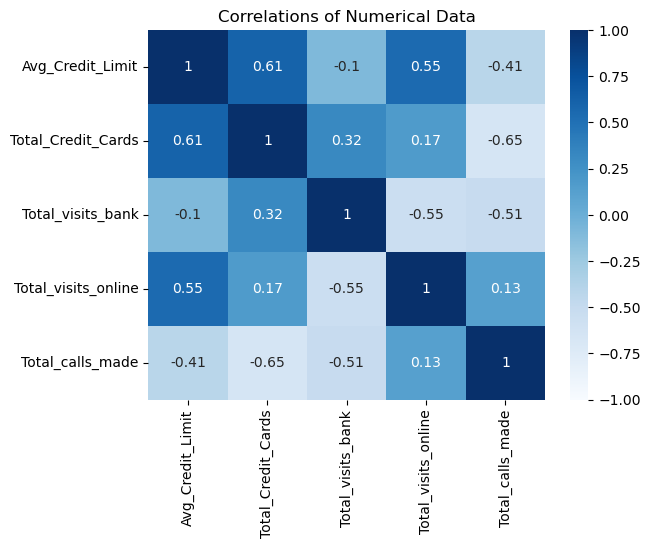

In [357]:
# run corr with sns.heatmap
#plt.figure(figsize = (10, 10))
sns.heatmap(cdata.iloc[:, 2:].corr(), vmin = -1, vmax = 1, 
            annot = True, cmap = 'Blues')
plt.title('Correlations of Numerical Data')

plt.show()

### Findings
- Median and mean
1. How is the distrubution of average credit limit of customer? See histogram and boxplot
- Average credit limit is a right skewed distribution with mean 34,574.24 and median 18,000
2. What percenatage of the customers have never made a service-related call to the bank?
- 15% of customers or 97 customers have never made a service related call
- Highest percentage is 16% or 108 customers made 4 service related calls to the bank
- Lowest percentage is 4% or 26 cusutomers made 10 service related calls to the bank
3. What percentage of customers have never logged in to the online portal?
- 22% of customers or 144 customers never logged in to to the online portal
4. How many customers have never visited bank?
- 15% of customers or 100 customers never made a visit to the bank
5. How are the different variables correlated with each other?
- Highest positive correlation is Avg_Credit_Limit and Total_Credit Cards at 0.61
- Netgative correlation is Total_calls_made and Total_Credit_Cards at -0.65

### Bivariate Analysis

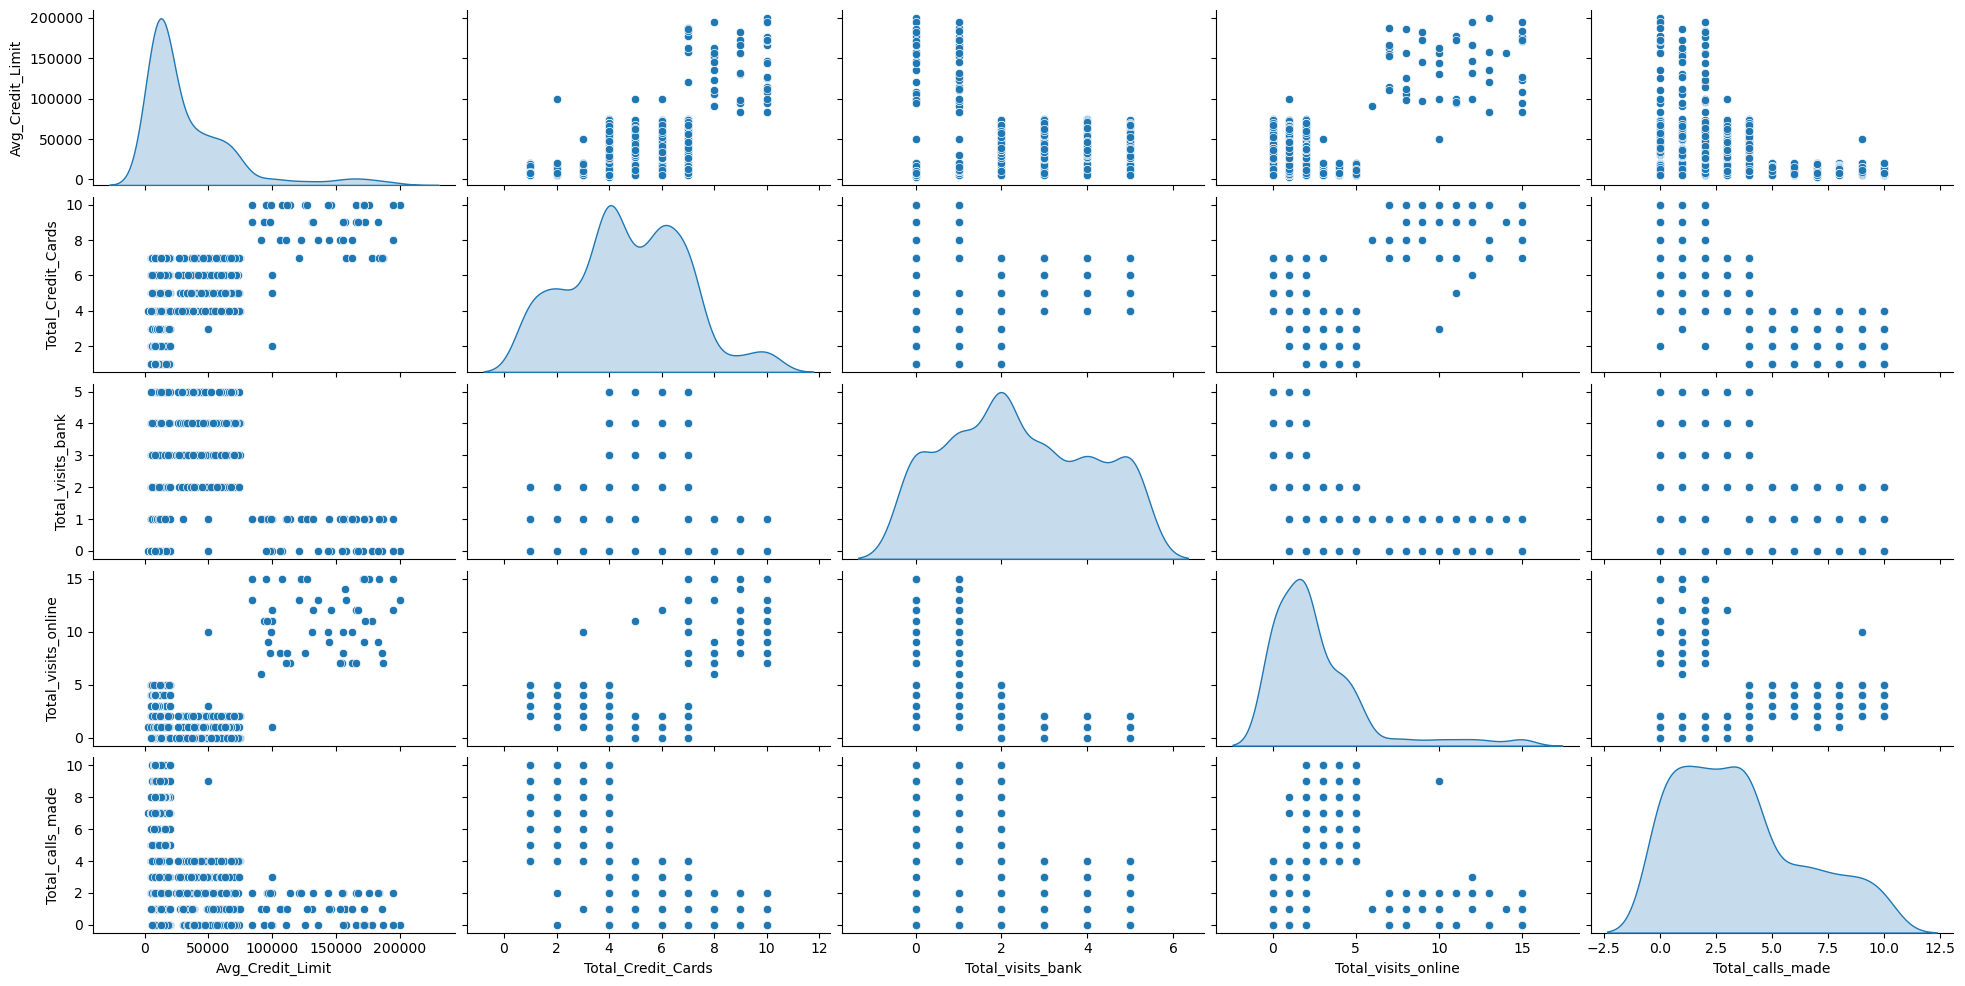

In [358]:
# running pairplot across variables
# run pairplot without SI.No and Customer Key
sns.pairplot(cdata.iloc[:,2:], height=2,aspect=2 , diag_kind='kde')
plt.show()

### Findings
-  Based on the distributions there are two right skewed distributions with outliers
- Avg_Credit_Limit and Total_visits_online have outliers
- For customers not using support channels, generate incentives and support workflows to guide them on their support journey

## Data Preprocessing



- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

#### Duplicate Row/Value Check

In [359]:
# duplicate value check
print("Duplicate Rows")
print("All Rows: ", cdata.duplicated().sum())

# re run dropping id columns
print("ID related columns filtered out: ", cdata.iloc[:, 2:].duplicated().sum())

Duplicate Rows
All Rows:  0
ID related columns filtered out:  11


#### Missing Value Check

In [360]:
# missing value check
cdata.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

#### Remove ID Related Columes

In [361]:
# remove id related columns
cdataAttr = cdata.iloc[:, 2:]

cdataAttr.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


#### Scale Data Using Zscore

In [362]:
# scale data using zscore
cdataScaled = cdataAttr.apply(zscore)

cdataScaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


## EDA

- It is a good idea to explore the data once again after manipulating it.

#### Univariate Analysis

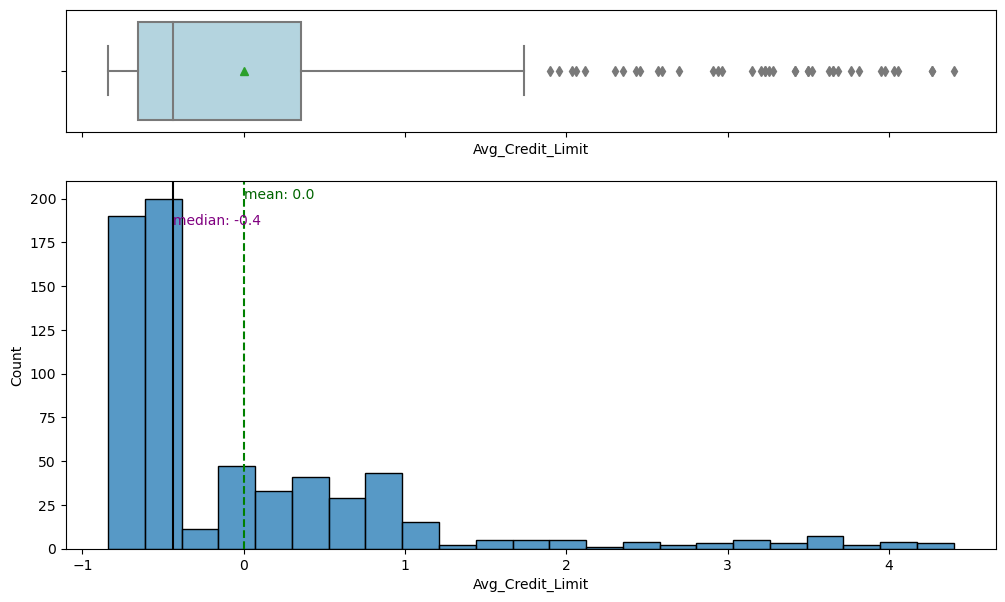

In [363]:
# re-run histogram_boxplot on features with outliers
# Avg_Credit_Limit
# Total_visits_online
histogram_boxplot(cdataScaled, 'Avg_Credit_Limit')

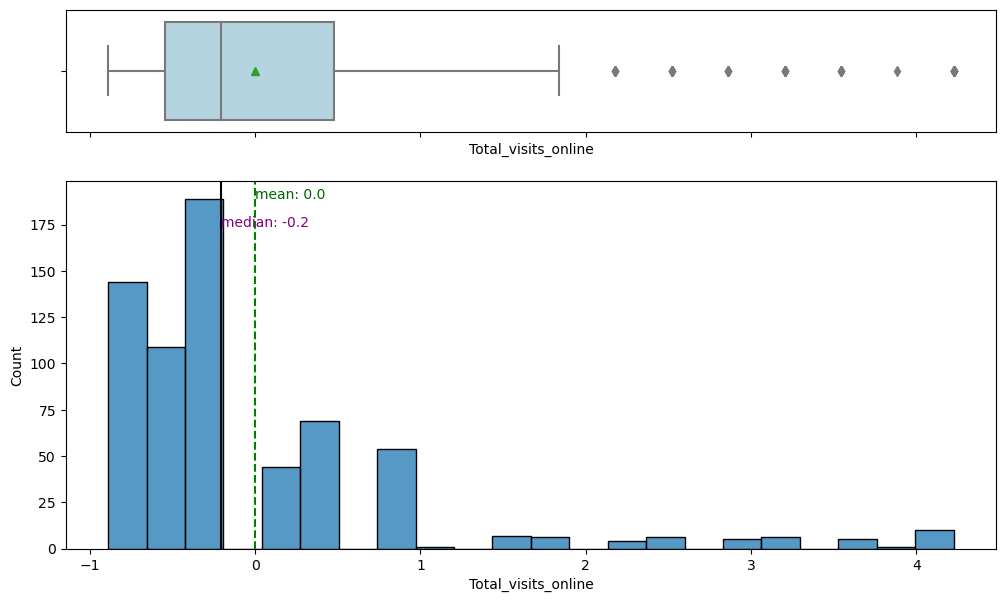

In [364]:
# re-run histogram_boxplot on features with outliers
# Avg_Credit_Limit
# Total_visits_online
histogram_boxplot(cdataScaled, 'Total_visits_online')

In [365]:
# re-run describe to understand outliers
cdataScaled.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,8.612639e-17,1.000758,-0.839808,-0.653623,-0.440840,0.357097,4.399975
Total_Credit_Cards,660.0,4.306320e-17,1.000758,-1.710864,-0.787585,0.135694,0.597334,2.443892
Total_visits_bank,660.0,-4.306320e-17,1.000758,-1.473731,-0.860451,-0.247170,0.979390,1.592670
Total_visits_online,660.0,7.536059e-17,1.000758,-0.888380,-0.547490,-0.206600,0.475180,4.224968
Total_calls_made,660.0,-8.612639e-17,1.000758,-1.251537,-0.902271,-0.203739,0.494794,2.241125


#### Bivariate Analysis

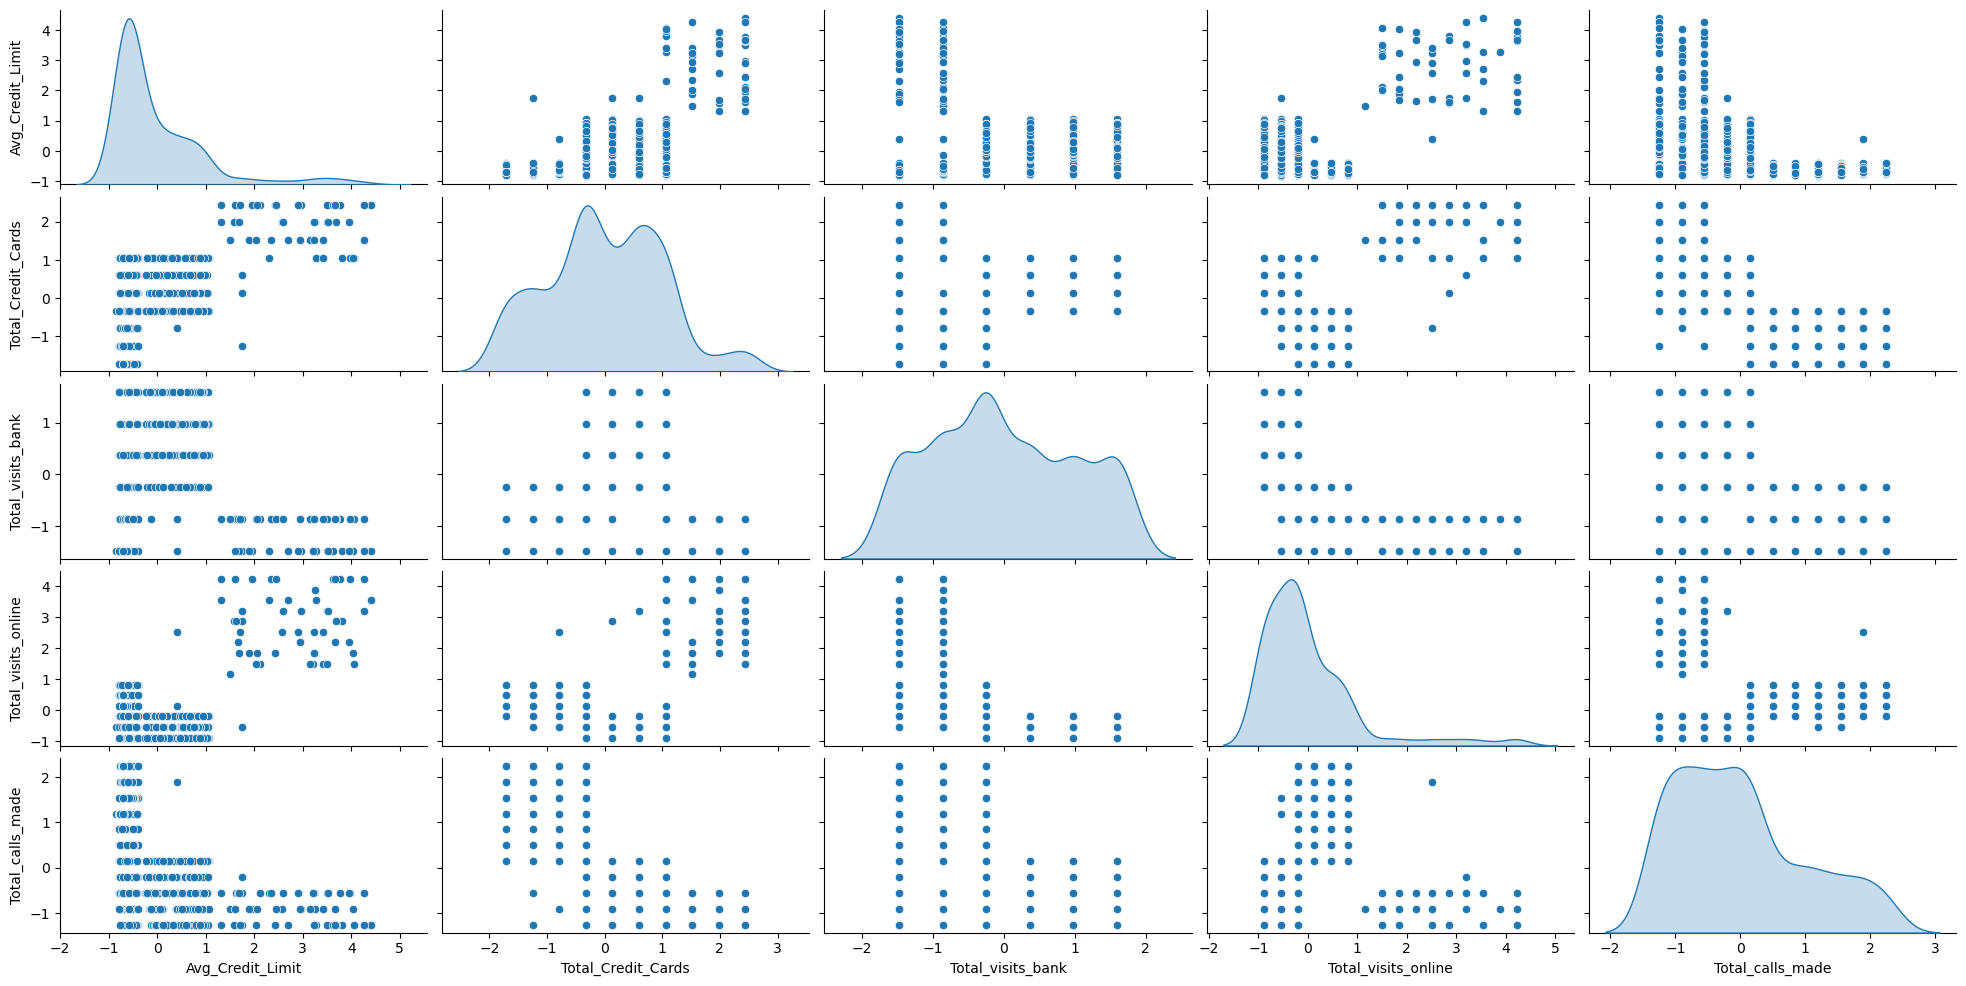

In [366]:
# running pairplot across variables
# run pairplot without SI.No and Customer Key
sns.pairplot(cdataScaled, height=2,aspect=2 , diag_kind='kde')
plt.show()

#### Correlation Analysis

In [367]:
# rerun corr() and heatmap chart to validate correlations on Scaled Data
# run corr to review correlations between dataset values
cdataScaled.corr()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.608860,-0.100312,0.551385,-0.414352
Total_Credit_Cards,0.608860,1.000000,0.315796,0.167758,-0.651251
Total_visits_bank,-0.100312,0.315796,1.000000,-0.551861,-0.506016
Total_visits_online,0.551385,0.167758,-0.551861,1.000000,0.127299
Total_calls_made,-0.414352,-0.651251,-0.506016,0.127299,1.000000


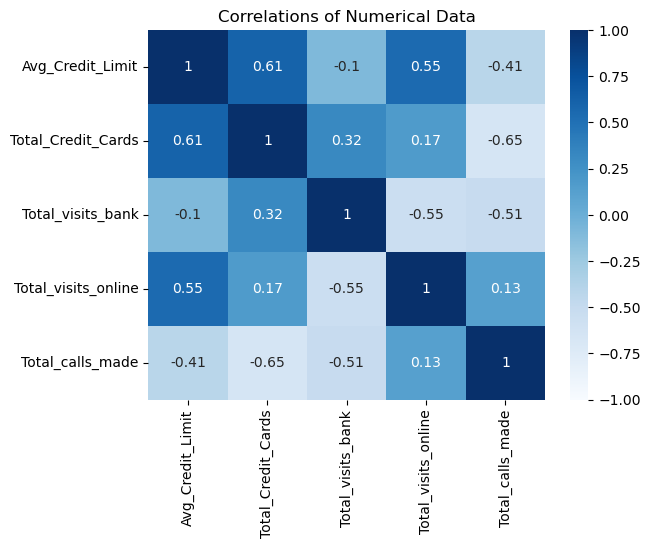

In [368]:
# run corr with sns.heatmap on Scaled Data
#plt.figure(figsize = (10, 10))
sns.heatmap(cdataScaled.corr(), vmin = -1, vmax = 1, 
            annot = True, cmap = 'Blues')
plt.title('Correlations of Numerical Data')

plt.show()

#### Outlier Detection

In [369]:
# Outlier Detection Avg_Credit_Limit
cdataAttr[cdataScaled['Avg_Credit_Limit'] > 4]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
630,200000,10,0,13,0
631,195000,8,0,15,0
632,187000,7,1,7,0
646,186000,7,0,8,1
650,195000,10,1,12,2


In [370]:
# Outlier Detection Total_visits_online
cdataAttr[cdataScaled['Total_visits_online'] > 4]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
620,108000,10,0,15,1
622,176000,10,1,15,2
628,84000,9,1,15,0
631,195000,8,0,15,0
639,184000,7,1,15,2
640,123000,8,1,15,2
644,127000,10,1,15,1
645,171000,10,0,15,0
653,95000,10,0,15,1
658,172000,10,1,15,0


### Findings
- After scaling the data, pairplot and corr() look the same
- For KMeans - remove outliers before running the algorithm
- For Hierarchical Clustering try including outliers

#### Remove Outliers for KMeans Clustering

In [371]:
# Create copies to avoid slicer warnings
cdataKmeans = cdataAttr.copy()

# Outlier Removal Total_visits_online
cdataKmeans = cdataKmeans[cdataScaled['Total_visits_online'] < 4]

# Outlier Removal Avg_Credit_Limit
cdataKmeans = cdataKmeans[cdataScaled['Avg_Credit_Limit'] < 4]

# re-run zscore
cdataScaledKmeans = cdataKmeans.apply(zscore)

cdataKmeans.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3
5,20000,3,0,1,8
6,100000,5,0,11,2
7,15000,3,0,1,1
8,5000,2,0,2,2
9,3000,4,0,1,7


In [418]:
# re run shape to count the number of columns
cdataKmeans.shape

(646, 5)

#### After Observing Initial Pass at Drawing a Dendogram for Hierarchical Clustering
#### Remove Outliers for Hierarchical Also

- Reran dendogram and the count of clusters remained the same after outlier treatment
- Silhouette scores reduced after outlier treatment
- Cophenetic correlations reduced after outlier treatment
- Keep outliers in for hierarchical clustering

## K-means Clustering

#### Run KMeans with 3 Clusters

In [427]:
# establish start time
t0 = time.time()

# run KMeans clustering with K = 3 first
cdata_model = KMeans(3, n_init = 'auto', random_state = 1)
cdata_model.fit(cdataScaledKmeans)

# run predictions, generate labels
prediction3 = cdata_model.predict(cdataScaledKmeans)

# record stop time
t1 = time.time()

# store total time in variable
total_time_k3 = t1 - t0

In [428]:
# create column named 'labels' and assign
# use cdataKmeans for analysis use copy on cdataAttr to avoid warning
# copy cdataScaled to cdataScaledKmeans to avoid warning
cdataKmeans3 = cdataKmeans.copy()
cdataScaledKmeans3 = cdataScaledKmeans.copy()

# assign predictions to newly created labels column
cdataKmeans3['labels'] = prediction3
cdataScaledKmeans3['labels'] = prediction3

cdataKmeans3.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,1
1,50000,3,0,10,9,0
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,2
5,20000,3,0,1,8,0
6,100000,5,0,11,2,2
7,15000,3,0,1,1,0
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0


In [429]:
# run groupby to further analyze
# run analysis of means of feature values for each cluster
cdata_Kmeans3 = cdataKmeans3.groupby(['labels'])
cdata_Kmeans3.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536
1,33782.383420,5.515544,3.489637,0.981865,2.000000
2,134694.444444,8.638889,0.611111,9.861111,1.166667


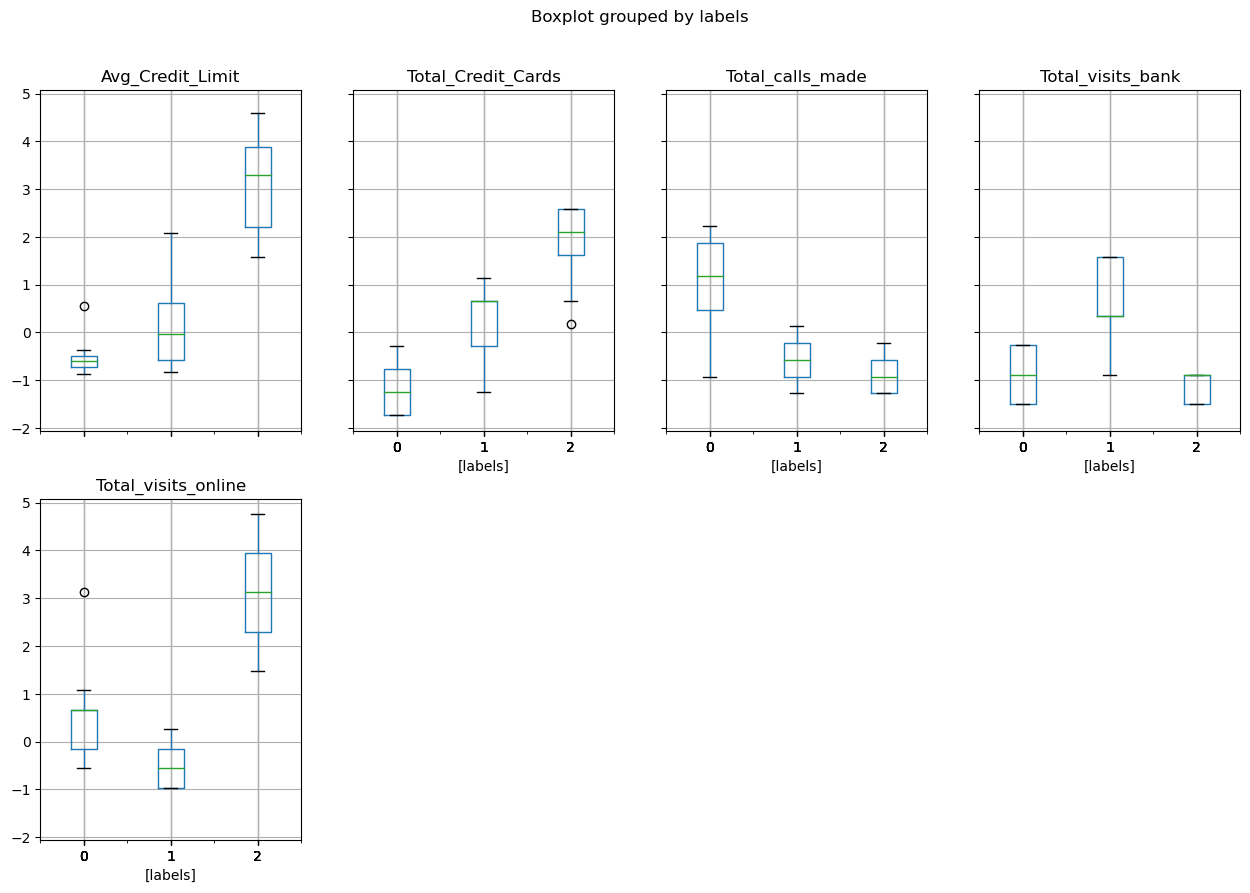

In [375]:
# run boxplot to visualize
cdataScaledKmeans3.boxplot(by = 'labels', layout = (2,4), figsize = (15,10))
plt.show()

#### Capture Silhouette Score for KMeans with 3 Clusters

In [430]:
#run average values for all clusters
silhouette_avg_kmeans3 = silhouette_score(cdataScaledKmeans3, prediction3)

print(silhouette_avg_kmeans3)

0.5333845037028604


#### Evaluate Optimal Number of Clusters for KMeans Clustering

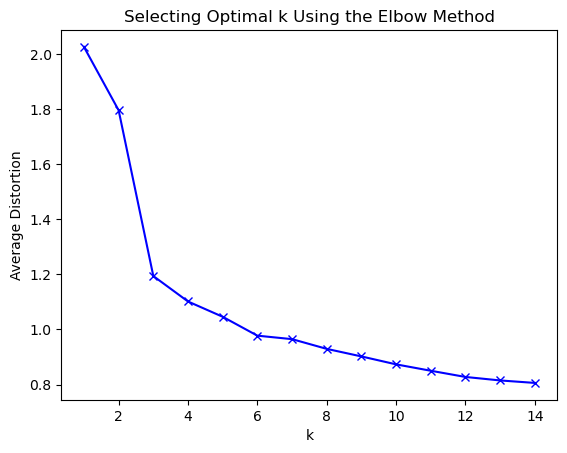

In [377]:
# evaluate the optimal number of clusters
# look for the 'elbow'
clusters = range(1,15)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters = k, n_init = 'auto', random_state = 1)
    model.fit(cdataScaledKmeans)
    prediction = model.predict(cdataScaledKmeans)
    meanDistortions.append(sum(np.min(cdist(cdataScaledKmeans, model.cluster_centers_,
                                           'euclidean'), axis = 1)) / cdataScaledKmeans.shape[0])
    
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting Optimal k Using the Elbow Method')
plt.show()

#### Run KMeans with 6 Clusters

In [455]:
# establish start time
t0 = time.time()

# run KMeans clustering with K = 5 after elbow method
cdata_model = KMeans(6, n_init = 'auto', random_state = 1)
cdata_model.fit(cdataScaledKmeans)

# run predictions, generate labels
prediction6 = cdata_model.predict(cdataScaledKmeans)

# record stop time
t1 = time.time()

# store total time in variable
total_time_k6 = t1 - t0

In [456]:
# copy cdataScaled to cdataScaledKmeans to avoid warning
cdataKmeans6 = cdataKmeans.copy()
cdataScaledKmeans6 = cdataScaledKmeans.copy()

# assign predictions to newly created labels column
cdataKmeans6['labels'] = prediction6
cdataScaledKmeans6['labels'] = prediction6

# run analysis of means of feature values for each cluster
cdata_Kmeans6 = cdataKmeans6.groupby(['labels'])
cdata_Kmeans6.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,11938.053097,2.610619,0.946903,3.433628,5.221239
1,19162.162162,5.648649,2.477477,0.981982,2.045045
2,134694.444444,8.638889,0.611111,9.861111,1.166667
3,60190.476190,5.420635,3.103175,0.865079,1.984127
4,12414.414414,2.207207,0.918919,3.675676,8.549550
5,22342.281879,5.496644,4.570470,1.080537,1.979866


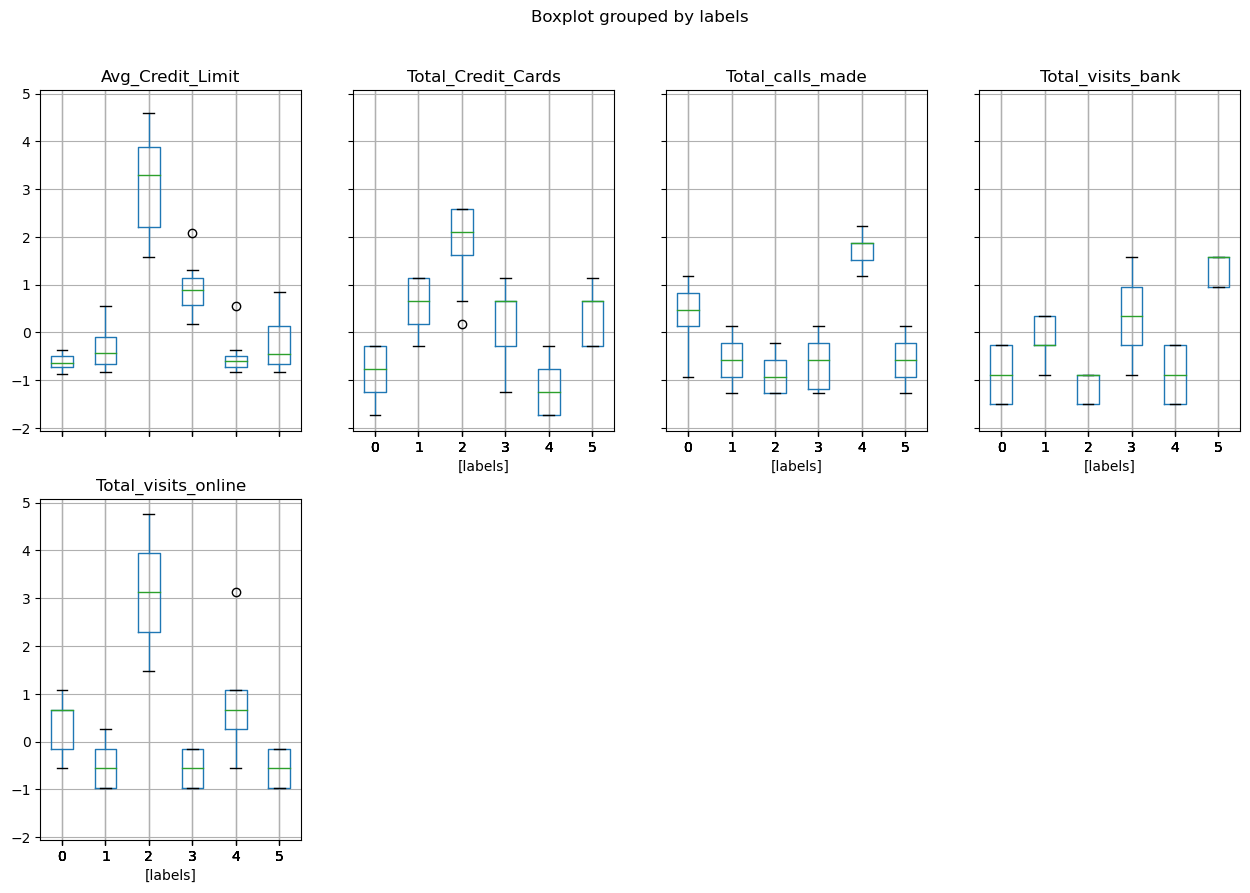

In [457]:
# run boxplot to visualize feature values for each cluster
cdataScaledKmeans6.boxplot(by = 'labels', layout = (2,4), figsize = (15,10))
plt.show()

#### Capture Silhuette Score of KMeans with 5 Clusters

In [458]:
#run average values for all clusters
silhouette_avg_kmeans6 = silhouette_score(cdataScaledKmeans6, prediction5)

print(silhouette_avg_kmeans6)

0.5420592095090941


### Findings of Optimal Number of Clusters
- The cluster count of 3 actually looks good based on elbow method
- Would be reasonable to investigate cluster count of 6 as well
- Silhouette score is greater for 6 Cluster KMeans than 4 Cluster
- KMeans with 6 Clusters Silhouette = 0.542
- KMeans with 3 Clusters Silhouette = 0.533

## Hierarchical Clustering

#### Run Agglomerative with 3 Clusters, Distance - Euclidean, and Linkage - Average

In [431]:
# establish start time
t0 = time.time()

# run agglomerative clustering
model_hier3 = AgglomerativeClustering(n_clusters=3, 
                                      metric = 'euclidean',  
                                      linkage = 'average')

model_hier3.fit(cdataScaled)

# record stop time
t1 = time.time()

# store total time in variable
total_hier3 = t1 - t0

In [432]:
# create column named 'labels' and assign
# use cdataHier3 for analysis use copy on cdataAttr to avoid warning
# copy cdataScaled to cdataScaledHier3 to avoid warning
cdataHier3 = cdataAttr.copy()
cdataScaledHier3 = cdataScaled.copy()

# assign labels to dataset to run groupby
cdataHier3['labels'] = model_hier3.labels_
cdataScaledHier3['labels'] = model_hier3.labels_

# run head() to check df and verify labels
cdataHier3.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1
5,20000,3,0,1,8,2
6,100000,5,0,11,2,1
7,15000,3,0,1,1,2
8,5000,2,0,2,2,2
9,3000,4,0,1,7,2


In [433]:
# run groupby to further analyze
cdata_cluster_Hier3 = cdataHier3.groupby(['labels'])
cdata_cluster_Hier3.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12197.309417,2.403587,0.928251,3.560538,6.883408


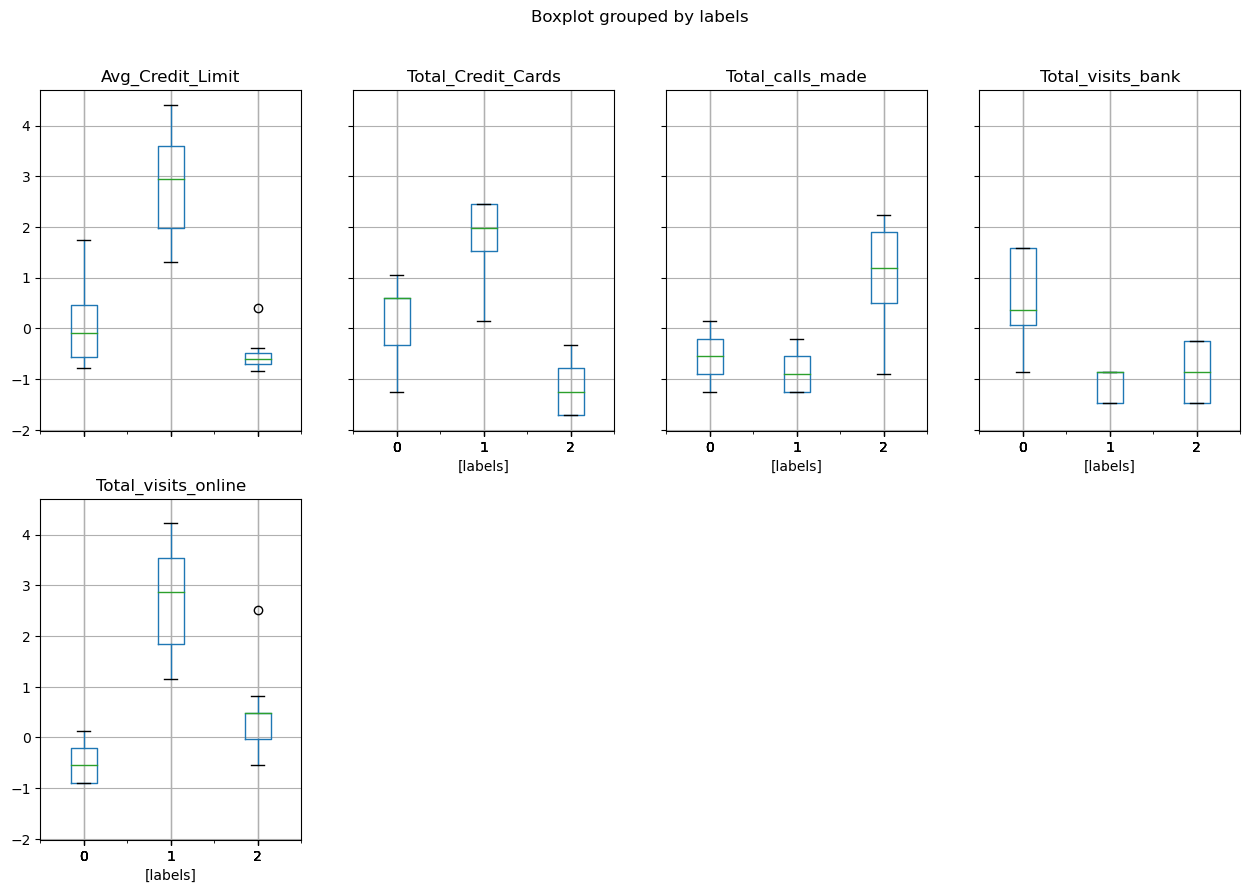

In [434]:
# run boxplot to visualize feature values for each cluster
# for hierarchical with 3 clusters
cdataScaledHier3.boxplot(by = 'labels', layout = (2,4), figsize = (15,10))
plt.show()

In [435]:
#run average values for all clusters
silhouette_avg_hier3 = silhouette_score(cdataScaledHier3, model_hier3.labels_)

print(silhouette_avg_hier3)

0.5909904735965409


## Cluster Profiling and Comparison

### Measure Cophenetic Correlation to Understand Optimal Distance and Linkage
- Distance measure: euclidean, Linkage: average
- Distance measure: euclidean, Linkage: centroid
- Create a function get_cophenet and iterate over two vectors

In [436]:
# create function that takes data as input and returns cophenetic correlation
# metric/distance measure
# linkage method

def get_cophenet(data, metric = 'euclidean', method = 'average'):
    """
    Measures cophenetic correlation for hierarchical clustering approaches

    data: scaled dataframe
    metric: distance measure
    method: linkage approach
    """
    Z = linkage(data, metric = metric, method = method)
    c, coph_dists = cophenet(Z, pdist(data))
    
    c = round(c, 6)
    
    print(f"Measure: {metric}, Linkage: {method}, Cophenetic Correlation: {c}")
    

In [437]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

# centroid requires distance to be euclidean, run that separately
# median requires distance to be euclidean, run that separetly
# ward requires distance to be euclidean, run that separately
distances = ['euclidean', 'cityblock', 'minkowski', 'seuclidean', 'jaccard', 'chebyshev']
linkages = ['single', 'complete', 'average', 'weighted']

for i in distances:
    for j in linkages:
        get_cophenet(cdataScaled, i, j)
        
get_cophenet(cdataScaled, 'euclidean', 'centroid')
get_cophenet(cdataScaled, 'euclidean', 'median')
get_cophenet(cdataScaled, 'euclidean', 'ward')

Measure: euclidean, Linkage: single, Cophenetic Correlation: 0.739122
Measure: euclidean, Linkage: complete, Cophenetic Correlation: 0.859973
Measure: euclidean, Linkage: average, Cophenetic Correlation: 0.897708
Measure: euclidean, Linkage: weighted, Cophenetic Correlation: 0.886175
Measure: cityblock, Linkage: single, Cophenetic Correlation: 0.725238
Measure: cityblock, Linkage: complete, Cophenetic Correlation: 0.873148
Measure: cityblock, Linkage: average, Cophenetic Correlation: 0.896329
Measure: cityblock, Linkage: weighted, Cophenetic Correlation: 0.882552
Measure: minkowski, Linkage: single, Cophenetic Correlation: 0.739122
Measure: minkowski, Linkage: complete, Cophenetic Correlation: 0.859973
Measure: minkowski, Linkage: average, Cophenetic Correlation: 0.897708
Measure: minkowski, Linkage: weighted, Cophenetic Correlation: 0.886175
Measure: seuclidean, Linkage: single, Cophenetic Correlation: 0.739122
Measure: seuclidean, Linkage: complete, Cophenetic Correlation: 0.859973
M

### Findings
- Distance: euclidean, Linkage: average has the best cophenetic correlation with 0.8977
- Distance: seuclidean, Linkage: average has the second best cophenetic correlation with 0.8977
- Distance: minkowsky, Linkage: average has a tie for second best cophenetic correlation with 0.8977

#### Run Dendrogram For Hierarchical Clustering to Understand Optimal Number of Clusters

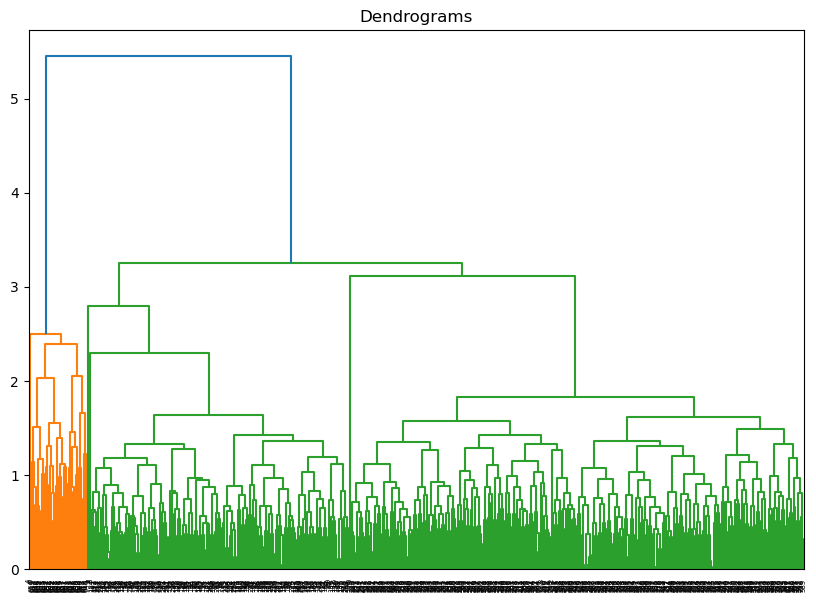

In [460]:
# Dendogram for Heirarchical Clustering
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = dendrogram(linkage(cdataScaled, method='average'))

In [439]:
# re-run hierarchical with 3 and 4 clusters but with seuclidean distance and linkage average

# establish start time
t0 = time.time()

# run agglomerative clustering
model_seu_hier3 = AgglomerativeClustering(n_clusters=3, metric = 'seuclidean',
                                          linkage = 'average')

model_seu_hier3.fit(cdataScaled)

# record stop time
t1 = time.time()

# store total time in variable
total_seu_hier3 = t1 - t0

In [440]:
# run copies to avoid indexing warnings
cdataHier3 = cdataAttr.copy()
cdataScaledHier3 = cdataScaled.copy()


# assign labels to dataset to run groupby
cdataScaledHier3['labels'] = model_seu_hier3.labels_
cdataHier3['labels'] = model_seu_hier3.labels_

# run groupby to further analyze
cdata_seu_Hier3 = cdataHier3.groupby(['labels'])
cdata_seu_Hier3.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12197.309417,2.403587,0.928251,3.560538,6.883408


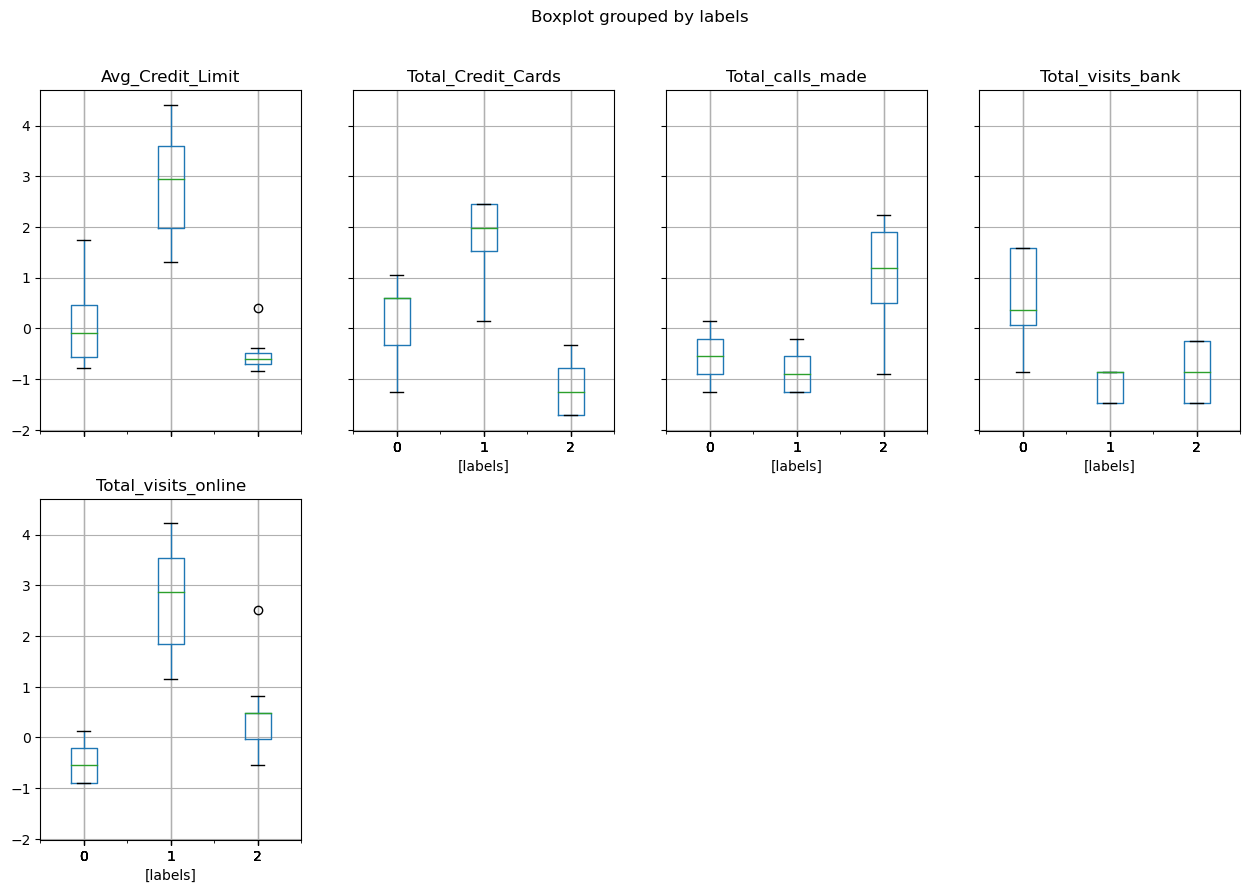

In [441]:
# run boxplot to visualize feature values for each cluster
# for hierarchical with 3 clusters
cdataScaledHier3.boxplot(by = 'labels', layout = (2,4), figsize = (15,10))
plt.show()

In [442]:
#run average values for all clusters
silhouette_avg_seu_hier3 = silhouette_score(cdataScaledHier3, model_seu_hier3.labels_)

print(silhouette_avg_seu_hier3)

0.5909904735965409


In [465]:
# re-run hierarchical with 3 and 4 clusters but with seuclidean distance and linkage average

# establish start time
t0 = time.time()

# run agglomerative clustering
model_seu_hier4 = AgglomerativeClustering(n_clusters=4, metric = 'seuclidean',
                                          linkage = 'average')

model_seu_hier4.fit(cdataScaled)

# record stop time
t1 = time.time()

# store total time in variable
total_seu_hier4 = t1 - t0

In [466]:
# run copies to avoid indexing warnings
cdataHier4 = cdataAttr.copy()
cdataScaledHier4 = cdataScaled.copy()

# assign labels to dataset to run groupby
cdataHier4['labels'] = model_seu_hier4.labels_
cdataScaledHier4['labels'] = model_seu_hier4.labels_


# run groupby to further analyze
cdata_seu_Hier4 = cdataHier4.groupby(['labels'])
cdata_seu_Hier4.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,12197.309417,2.403587,0.928251,3.560538,6.883408
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,33541.450777,5.520725,3.492228,0.984456,2.010363
3,100000.000000,2.000000,1.000000,1.000000,0.000000


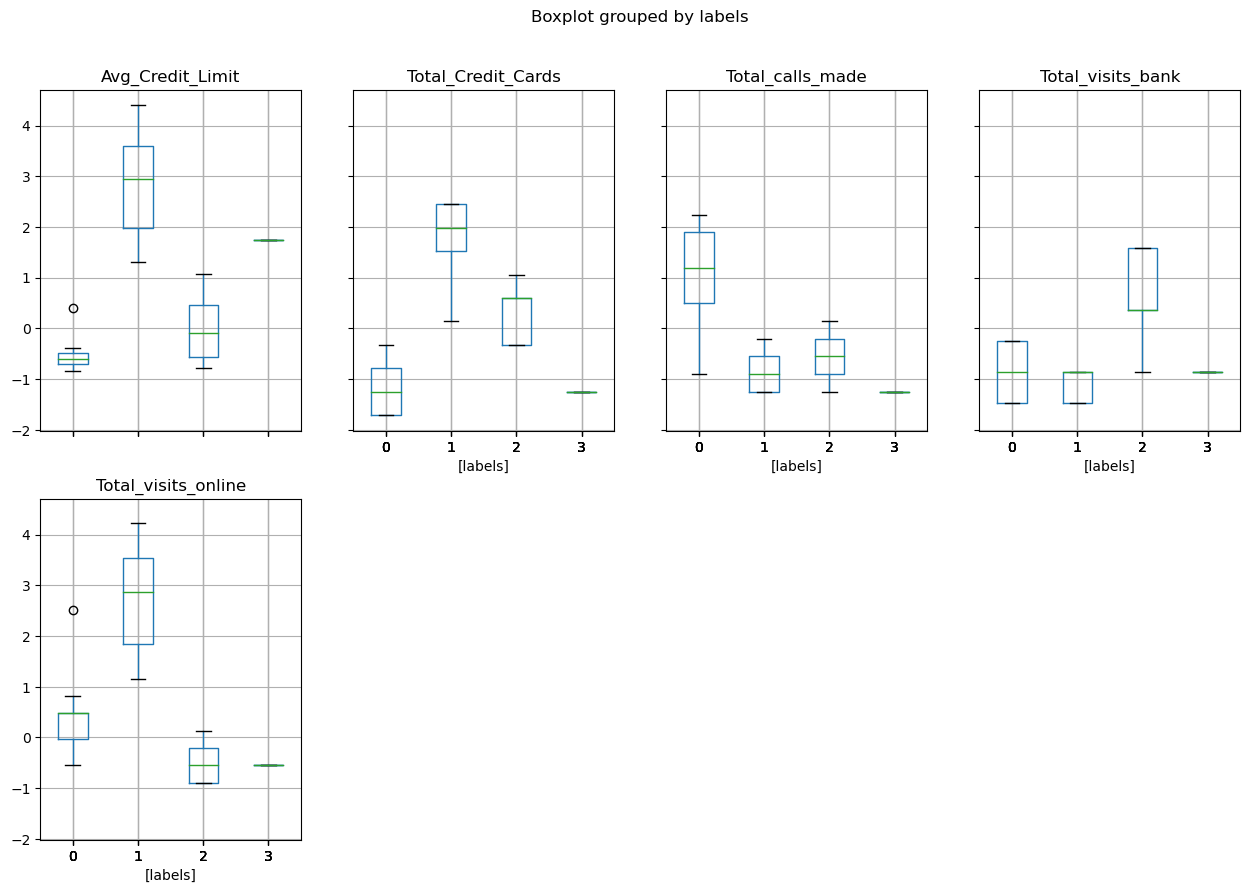

In [467]:
# run boxplot to visualize feature values for each cluster
# for hierarchical with 5 clusters
# distance: seuclidean
# linkage: average
cdataScaledHier4.boxplot(by = 'labels', layout = (2,4), figsize = (15,10))
plt.show()

In [468]:
#run average values for all clusters
silhouette_avg_seu_hier4 = silhouette_score(cdataScaledHier4, model_seu_hier4.labels_)

print(silhouette_avg_seu_hier4)

0.5376007389773523


## K-means vs Hierarchical Clustering

You compare several things, like:
- Which clustering technique took less time for execution?
- Which clustering technique gave you more distinct clusters, or are they the same?
- How many observations are there in the similar clusters of both algorithms?
- How many clusters are obtained as the appropriate number of clusters from both algorithms?

You can also mention any differences or similarities you obtained in the cluster profiles from both the clustering techniques.

In [469]:
# output execution time for clustering methods
print("Time to Execute:")
print("KMeans with n_cluster = 3: ", total_time_k3)

print("KMeans with n_cluster = 6: ", total_time_k6)

print("Hierarchical clustering euclidean with 3 clusters: ", total_hier3)

print("Hierarchical clustering seuclidean with 3 clusters: ", total_seu_hier3)

print("Hierarchical clustering seuclidean with 4 clusters: ", total_seu_hier4)

print("\nSilhouette Scores:")
print("KMeans with n_clusters = 3: ", silhouette_avg_kmeans3)
print("Kmeans with n_clusters = 6: ", silhouette_avg_kmeans6)
print("Hierarchical clustering with euclidean with 3 clusters: ", silhouette_avg_hier3)
print("Hierarchical clustering with seuclidean with 3 clusters: ", silhouette_avg_seu_hier3)
print("Hierarchical clustering with seuclidean with 4 clusters: ", silhouette_avg_seu_hier4)

Time to Execute:
KMeans with n_cluster = 3:  0.02794027328491211
KMeans with n_cluster = 6:  0.011163949966430664
Hierarchical clustering euclidean with 3 clusters:  0.010251998901367188
Hierarchical clustering seuclidean with 3 clusters:  0.0161130428314209
Hierarchical clustering seuclidean with 4 clusters:  0.01452183723449707

Silhouette Scores:
KMeans with n_clusters = 3:  0.5333845037028604
Kmeans with n_clusters = 6:  0.5420592095090941
Hierarchical clustering with euclidean with 3 clusters:  0.5909904735965409
Hierarchical clustering with seuclidean with 3 clusters:  0.5909904735965409
Hierarchical clustering with seuclidean with 4 clusters:  0.5376007389773523


#### Findings

- Hierarchical clustering with euclidean or seuclidean distance and average linkage performed best based on silhouette score
- Silhouette score of 0.59099 was best for 3 clusters, euclidean/seuclidean and average linkage
- Outliers were included with hierarchical clustering, but any zcores greater than 4 were removed from KMeans clustering inputs
- KMeans with 3 clusters took the longest to execute at 0.0279
- Hierarchical clustering with 3 clusters, euclidean distance, average linkage took 0.01025
- Drawing dendogram and running elbow method generated different optimal cluster counts
- KMeans elbow method generated 3 or 6 based on judgement
- Hierarchical generated 3 clusters using the dendogram drawing
- Means tabular data show similar data between KMeans and Hierarchical

## Actionable Insights and Recommendations

- We have three demographics or groupings. Each grouping requires a different approach

#### High Spenders
- First we have high spenders that visit online frequently
- High spenders have the most credit cards
- The recommendation for high spenders is to target retention, lean into customer service workflow, and seek out partnerships with local businesses for rewards
- If high spenders visit online support often, we need to provide a knowledge base or resources page that answers frequently asked questions
- AllLife bank should also consider routing more complex questions to a phone queue for a scheduled call back
- Additionally, periodically (quarterly for example) offer scheduled visits at the bank to ensure High Spenders are being provided with the best customer service possible.
- Lastly, AllLife can establish cash back rewards by shopping at specific businesses AllLife partners with. For a fee paid to AllLife, businesses can advertise online and through emailers to Heavy Spenders from AllLife Bank
- Luxury goods, travel, and hospitality industry can establish partnerships with AllLife to gain access to the High Spender demographic

#### Medium Spenders
- Medium Spenders tend to visit the bank more frequently than High Spenders, and generate fewer online service tickets
- Medium Spenders also call phone support more frequently than going online
- Recommendation is to store correspondence and notes from bank visits online
- By storing service artifacts online, Medium Spenders have a way to track progress of service tickets
- Schedule phone call follow ups after each bank visit to ensure issues are resolved
- Offer cash bank for gas, travel, and groceries
- Partner with local gas stations, and grocery stores
- Offer new credit cards to Medium Spenders with cash back amenities
- Periodically share a survey with the Medium Spender to take a pulse on satisfaction
- When surveys are shared, offer cashbak rewards for completing the survey

#### Growth Opportunities
- Growth Opportunities have the lowest credit limit and the fewest number of credit cards
- Growth Opportunities spend the most time on the phone out of the three groupings
- Ensure correspondence of phone support tickets are kept online
- Periodically request an online survey, and offer cashback rewards for completing the survey
- Periocially offer new credit cards to provide a higher credit card limit
- With new card offers, share amenities like cashback rewards for gas, groceries, and everyday necessities

In [470]:
# redisplay means for hierarchical clustering with 3 clusters
cdata_seu_Hier3.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12197.309417,2.403587,0.928251,3.560538,6.883408


___